# **05_PredictingAsthma**

## Objectives

* Fit and evaluate a classification model to predict whether a patient will have asthma, or not.

## Inputs

* Raw data generated from "01_DataCollection". Saved as: inputs\datasets\raw\asthma_disease_data.csv
* Confirmation of transformations and required scaling for continuous / numerical features from 04_FeatureEngineering; no additional data cleaning was required as no missing data.

## Outputs

* Data cleaning and Feature Engineering pipeline
* Modeling pipeline

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/AsthmaBurden'

---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE

from feature_engine.wrappers import SklearnTransformerWrapper

from xgboost import XGBClassifier

# Pipeline with all features 

Load data - Collection dataset was loaded and the target feature (Diagnosis) was assigned 

In [5]:
df = pd.read_csv("outputs/datasets/collection/asthma_disease_data.csv").drop(
    ["DoctorInCharge", "PatientID"], axis=1
)
target_var = "Diagnosis"
df.head(5)


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0


## Pipeline for data cleaning and feature engineering
---

1) Apply relevant learnings from 03_FeatureEngineering with regards to continuous features; reminder that no features were highly correlated (SmartCorrelatedSelection) and categorical features were already binary:

In [6]:
# Feature Engineering
def PipelineDataCleaningAndFeatureEngineering():
    """
    Custom function to apply Yeo-Johnson transformation"""
    pipeline_base = Pipeline(
        [
            (
                "yeojohnson_transform",
                SklearnTransformerWrapper(
                    transformer=PowerTransformer(method="yeo-johnson"),
                    variables=[
                        "BMI",
                        "LungFunctionFEV1",
                        "LungFunctionFVC",
                        "SleepQuality",
                    ],
                ),
            )
        ]
    )

    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('yeojohnson_transform', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,transformer,PowerTransformer()
,variables,"['BMI', 'LungFunctionFEV1', ...]"
,"method method: {'yeo-johnson', 'box-cox'}, default='yeo-johnson'The power transform method. Available methods are:- 'yeo-johnson' [1]_, works with positive and negative values- 'box-cox' [2]_, only works with strictly positive values",'yeo-johnson'
,"standardize standardize: bool, default=TrueSet to True to apply zero-mean, unit-variance normalization to thetransformed output.",True
,"copy copy: bool, default=TrueSet to False to perform inplace computation during transformation.",True


2. Due to the imbalanced nature of the dataset, little to no features were deemed to have a significant association with asthma diagnosis (minority sample). This was investigated further to understand overarching correlation with the target feature

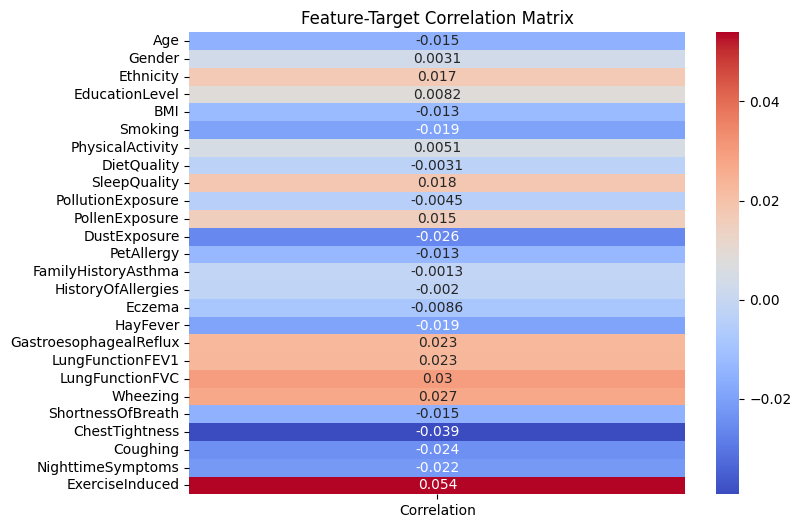

In [7]:
features = df.drop(["Diagnosis"], axis=1)
target = df["Diagnosis"]

correlation_matrix = features.corrwith(target)
plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(correlation_matrix, columns=["Correlation"]),
    annot=True,
    cmap="coolwarm",
    cbar=True,
)
plt.title("Feature-Target Correlation Matrix")
plt.show()

4. Define the classifier pipeline, apply feature scaling for continuous features and run pipeline for hyperparameter optimisation (taken from the Code Institutes "Churnometer" walkthrough project):

In [8]:
def PipelineClf(
    model,
    use_feature_selection=True,
    use_smote=True,
    smote_ratio=1.0,
    k_neighbors=20,
    feature_selection_threshold="median",
    min_features=1,
    smote_kind="borderline-1",
    use_scaling=True,
    class_weight="balanced",
    feature_selection_method="select_from_model",
):
    """
    Classification pipeline with optional feature scaling,
    and Borderline-SMOTE oversampling.
    """
    model_copy = clone(model)

    if "class_weight" in model_copy.get_params():
        model_copy.set_params(class_weight=class_weight)

    steps = []

    # Scaling
    if use_scaling:
        steps.append(("scaler", StandardScaler()))

    # SMOTE
    if use_smote:
        steps.append(
            (
                "smote",
                BorderlineSMOTE(
                    kind=smote_kind,
                    sampling_strategy=smote_ratio,
                    k_neighbors=k_neighbors,
                    random_state=42,
                ),
            )
        )

    # Feature selection
    if use_feature_selection:
        if feature_selection_method == "select_from_model":
            selector = SelectFromModel(
                model_copy, threshold=feature_selection_threshold
            )
        elif feature_selection_method == "select_k_best":
            selector = SelectKBest(f_classif, k=min_features)
        elif feature_selection_method == "rfe":
            selector = RFE(model_copy, n_features_to_select=min_features)
        else:
            raise ValueError("Invalid feature selection method")

        steps.append(("feat_selection", selector))

    # Final model
    steps.append(("model", model_copy))

    return ImbPipeline(steps)

5. Use a customised function for hyperparameter optimisation (adapted from The Code Institutes walkthough through project, "Churnometer")

In [9]:
class HyperparameterOptimizationSearch:
    """
    Custom class for hyperparameter optimization.
    GridSearchCV and RandomizedSearchCV.
    """

    def __init__(
        self, models, params, search_type="grid", n_iter=10, random_state=None
    ):
        self.models = models
        self.params = params
        self.keys = list(
            models.keys()
        )  # Make sure this is a list, not a dict_keys object
        self.search_type = search_type.lower()
        self.n_iter = n_iter
        self.random_state = random_state
        self.searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=True):
        for key in self.keys:
            print(f"\nRunning {self.search_type.title()}SearchCV for {key} \n")

            model = PipelineClf(
                self.models[key]
            )  # keep your custom pipeline wrapper

            if self.search_type == "grid":
                search = GridSearchCV(
                    model,
                    self.params[key],
                    cv=cv,
                    n_jobs=n_jobs,
                    verbose=verbose,
                    scoring=scoring,
                    refit=refit,
                )
            elif self.search_type == "random":
                search = RandomizedSearchCV(
                    model,
                    self.params[key],
                    n_iter=self.n_iter,
                    cv=cv,
                    n_jobs=n_jobs,
                    verbose=verbose,
                    scoring=scoring,
                    refit=refit,
                    random_state=self.random_state,
                )
            else:
                raise ValueError(
                    "search_type must be either 'grid' or 'random'."
                )

            search.fit(X, y)
            self.searches[key] = search

    def score_summary(self, sort_by="mean_score"):
        """
        Returns a summary dataframe of the search results.
        """

        def row(key, scores, params):
            d = {
                "estimator": key,
                "min_score": np.min(scores),
                "max_score": np.max(scores),
                "mean_score": np.mean(scores),
                "std_score": np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.searches:
            search = self.searches[k]
            params = search.cv_results_["params"]
            all_scores = []

            # Iterate through the number of splits
            for i in range(len(search.cv_results_["mean_test_score"])):
                score_key = "split{}_test_score".format(i)
                if score_key in search.cv_results_:
                    scores = search.cv_results_[
                        score_key
                    ]  # Access the test scores for each split
                    all_scores.append(scores)
                else:
                    print(f"Warning: {score_key} not found in cv_results_")

            if all_scores:
                all_scores = np.array(
                    all_scores
                ).T  # Transpose to align with params
                for p, s in zip(params, all_scores):
                    rows.append(row(k, s, p))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = [
            "estimator",
            "min_score",
            "mean_score",
            "max_score",
            "std_score",
        ]
        columns += [c for c in df.columns if c not in columns]
        return df[columns], self.searches



## Preparing the data
---

1. Update Age, Ethnicity and Education to align with 03_DataExploration

In [10]:
df['Age'] = df['Age'].astype(float)

# Encode categories
df['Ethnicity'] = df['Ethnicity'].replace({0:0, 1:1, 2:1, 3:1})
df['EducationLevel'] = df['EducationLevel'].replace({1:1, 2:1, 3:0})

df.head(10)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis
0,63.0,0,1,0,15.848744,0,0.894448,5.488696,8.701003,7.388481,...,0,1.369051,4.941206,0,0,1,0,0,1,0
1,26.0,1,1,1,22.757042,0,5.897329,6.341014,5.153966,1.969838,...,0,2.197767,1.702393,1,0,0,1,1,1,0
2,57.0,0,1,1,18.395396,0,6.739367,9.196237,6.840647,1.460593,...,0,1.698011,5.022553,1,1,1,0,1,1,0
3,40.0,1,1,1,38.515278,0,1.404503,5.826532,4.253036,0.581905,...,0,3.032037,2.300159,1,0,1,1,1,0,0
4,61.0,0,0,0,19.283802,0,4.604493,3.127048,9.625799,0.980875,...,0,3.470589,3.067944,1,1,1,0,0,1,0
5,21.0,0,1,0,21.812975,0,0.470044,1.759118,9.549262,1.711446,...,0,2.328191,5.898515,1,0,1,0,0,1,0
6,45.0,1,1,1,30.245954,1,9.371784,7.030507,5.746128,7.664306,...,0,2.995100,1.701512,1,1,1,0,0,0,0
7,26.0,0,0,1,26.048416,1,8.344096,1.626484,6.431179,6.939046,...,0,2.069343,4.012260,1,0,0,1,1,1,0
8,49.0,1,1,1,32.676204,0,2.690256,3.920034,5.843645,3.180421,...,1,1.761242,5.190931,1,1,1,1,0,0,0
9,45.0,1,1,1,29.910298,0,2.895720,2.607700,7.234908,1.711722,...,0,2.848420,5.771022,1,0,0,0,1,1,0


2. Split the train and test set with stratifications, due to the small base for analyses

In [11]:
# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_var], axis=1), 
    df[target_var],
    test_size=0.3,
    random_state=0,
    stratify=df[target_var]
)

# Check shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1674, 26)
y_train: (1674,)
X_test: (718, 26)
y_test: (718,)


3. Check the split of the target variable across the train and test set

In [12]:
# Check counts
print("Asthma count in train:", y_train.value_counts())
print("Asthma count in test:", y_test.value_counts())

Asthma count in train: Diagnosis
0    1587
1      87
Name: count, dtype: int64
Asthma count in test: Diagnosis
0    681
1     37
Name: count, dtype: int64


4. Apply transformations to the train and test set

In [13]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)

## Grid Search CV - Sklearn


---

Multiple machine learning models were evaluated to provide baseline performance and enable easy comparison:
* Linear models include logistic regression (predicts probability for binary outcomes using a logistic function) and ridge classifier.
* Tree-based models split the data based on feature thresholds to make predictions, and hangle non-linearities (decision tree, random forest)
* Boosting models look at each new model, and corrects errors of the previous one sequentially (XGBoost, CatBoost, AdaBoost, Gradient Boosting)

In [14]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, random_state=0, class_weight="balanced"
    ),
    "XGBClassifier": XGBClassifier(
        random_state=0,
        scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(
        random_state=0, class_weight="balanced"
    ),
    "RandomForestClassifier": RandomForestClassifier(
        random_state=0, class_weight="balanced"
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(
        random_state=0, class_weight="balanced"
    ),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# Optional: keep empty hyperparameter grids for now
params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Primary metrics for choosing the best model:
* Recall for asthma ≥ 0.80 – to minimize false negatives (diagnosed asthma cases predicted as non-asthma), ensuring sensitive detection of patients who actually have asthma.
* Precision for asthma ≥ 0.60 – to reduce false positives, avoiding over-identifying healthy patients as asthmatic.

GridSearchCV was run evaluate the model performance using the default hyperparameters; 5-fold cross-validation to obtain a robust estimate of model performance and reduce the impact of random variation in the training data.

In [15]:
# Define your StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up your search (assuming models_quick_search and params_quick_search are defined)
search = HyperparameterOptimizationSearch(
    models=models_quick_search, params=params_quick_search
)

# Fit the search with the StratifiedKFold CV and custom scoring (recall)
search.fit(
    X_train, y_train, scoring="recall", n_jobs=-1, cv=cv)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Recall results:

In [16]:
search_summary, search_pipelines = search.score_summary(sort_by='mean_score')
search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.235294,0.235294,0.235294,0.0
1,XGBClassifier,0.117647,0.117647,0.117647,0.0
5,ExtraTreesClassifier,0.058824,0.058824,0.058824,0.0
2,DecisionTreeClassifier,0.0,0.0,0.0,0.0
3,RandomForestClassifier,0.0,0.0,0.0,0.0
4,GradientBoostingClassifier,0.0,0.0,0.0,0.0
6,AdaBoostClassifier,0.0,0.0,0.0,0.0


Among the tested algorithms, the best-performing model was the XXXXX. However, this is significantly below the requirements for the business case, meaning hyperparamters will need to be optimised. To understand best ways for tuning Hyperparameters, online sources, such as geeksforfeeks and towardsdatascience were utilised.

In [17]:
# Define the Logistic Regression model
models_search = {
    "LogisticRegression": LogisticRegression(random_state=42)
}

# Define the hyperparameters for Logistic Regression
logreg_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced', None],
    'model__max_iter': [100, 500, 1000]
}

In [18]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the search and fit the model
search = HyperparameterOptimizationSearch(
    models=models_search,
    params={"LogisticRegression": logreg_params},
    search_type='random',  # Randomized search
    n_iter=50,  # Number of iterations for random search
    random_state=42
)

# Fit the search with training data
search.fit(
    X_train,
    y_train,
    cv=cv,  # Use StratifiedKFold as cross-validation
    scoring='recall',  # Using recall as the scoring metric
    n_jobs=-1  # Use all processors for parallel computation
)


Running RandomSearchCV for LogisticRegression 

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead 

Check results - Recall:

In [19]:
search_summary, search_pipelines = search.score_summary(sort_by='mean_score')
search_summary

,estimator,min_score,mean_score,max_score,std_score,model__solver,model__penalty,model__max_iter,model__class_weight,model__C
25,LogisticRegression,0.277778,0.427451,0.529412,0.094792,liblinear,l1,100,None,0.01
2,LogisticRegression,0.277778,0.427451,0.529412,0.094792,liblinear,l1,500,balanced,0.01
17,LogisticRegression,0.277778,0.427451,0.529412,0.094792,liblinear,l1,100,balanced,0.01
46,LogisticRegression,0.166667,0.301307,0.411765,0.091559,saga,l1,500,balanced,0.01
39,LogisticRegression,0.166667,0.301307,0.411765,0.091559,saga,l1,1000,balanced,0.01
7,LogisticRegression,0.222222,0.288235,0.352941,0.055935,liblinear,l2,1000,balanced,0.01
32,LogisticRegression,0.222222,0.288235,0.352941,0.055935,liblinear,l2,1000,None,0.01
10,LogisticRegression,0.222222,0.288235,0.352941,0.055935,liblinear,l2,500,None,0.01
37,LogisticRegression,0.222222,0.277124,0.352941,0.062088,saga,l1,500,balanced,1
29,LogisticRegression,0.222222,0.277124,0.352941,0.062088,saga,l1,100,balanced,100


In [20]:
y_pred = search_pipelines["LogisticRegression"].best_estimator_.predict(
    X_train
)

# Compute confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_pred)

print("Confusion Matrix:")
print(train_confusion_matrix)

Confusion Matrix:
[[810 777]
 [ 31  56]]


Define the best model and paramters for the best pipeline:

In [21]:
# State the best model
best_model = search_summary.iloc[0, 0]

# Get best parameters and best estimator
best_parameters = search_pipelines[best_model].best_params_
pipeline_clf = search_pipelines[best_model].best_estimator_

best_parameters, pipeline_clf

({'model__solver': 'liblinear',
  'model__penalty': 'l1',
  'model__max_iter': 500,
  'model__class_weight': 'balanced',
  'model__C': 0.01},
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('smote',
                  BorderlineSMOTE(k_neighbors=20, random_state=42,
                                  sampling_strategy=1.0)),
                 ('feat_selection',
                  SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                               random_state=42),
                                  threshold='median')),
                 ('model',
                  LogisticRegression(C=0.01, class_weight='balanced',
                                     max_iter=500, penalty='l1', random_state=42,
                                     solver='liblinear'))]))

## Assess Feature Importance
---

In [22]:
X_train.head(3)

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,PollutionExposure,...,HayFever,GastroesophagealReflux,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced
1655,33.0,0,0,0,1.195010,1,6.846289,9.280995,-1.778138,1.462679,...,1,1,0.084209,0.324279,1,1,1,0,1,1
548,41.0,0,1,0,-0.772265,0,0.179369,2.895126,-0.138626,7.944387,...,0,1,0.575845,0.746531,1,0,1,1,1,1
1260,58.0,0,0,0,-1.137647,0,9.178088,9.760681,0.553992,3.817210,...,0,1,0.608585,0.344299,1,1,0,0,0,1


From our pipeline, we're able to identify which features were selected (used in the model) and which ones were deemed important. As this dataset included a small pool of asthma patients, there was a high risk of overfitting the model. For this reason, SelectFromModel was limited to include the most important features only. In the dataset,6 features were selected.

{'scaler': StandardScaler(), 'smote': BorderlineSMOTE(k_neighbors=20, random_state=42, sampling_strategy=1.0), 'feat_selection': SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                             random_state=42),
                threshold='median'), 'model': LogisticRegression(C=0.01, class_weight='balanced', max_iter=500, penalty='l1',
                   random_state=42, solver='liblinear')}
* Features:
['ExerciseInduced', 'Gender', 'Ethnicity', 'Wheezing', 'SleepQuality', 'LungFunctionFEV1', 'DustExposure', 'FamilyHistoryAsthma', 'Smoking', 'NighttimeSymptoms', 'HayFever', 'ChestTightness', 'PetAllergy']


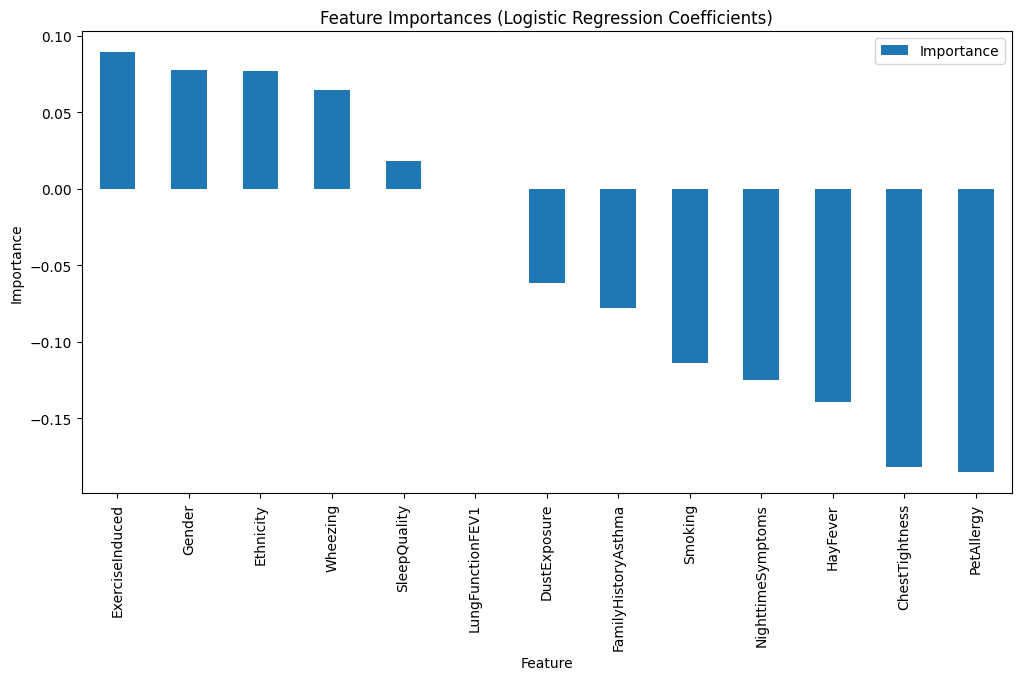

In [23]:
# Print pipeline steps
print(pipeline_clf.named_steps)

# Extract selected features
try:
    # Directly get support from SelectFromModel (no wrapper)
    if "feat_selection" in pipeline_clf.named_steps:
        selected_features = pipeline_clf["feat_selection"].get_support(
            indices=True
        )
        best_features_used_by_model = X_train.columns[selected_features]
    else:
        best_features_used_by_model = X_train.columns  # all features used

    # Get model coefficients (for LogisticRegression)
    feature_importance = pipeline_clf["model"].coef_[0]

    # Check lengths match
    if len(best_features_used_by_model) != len(feature_importance):
        print(
            f"Warning: feature count ({len(best_features_used_by_model)}) "
            f"does not match importance count ({len(feature_importance)})."
        )

    # Create DataFrame
    df_feature_importance = pd.DataFrame(
        {
            "Feature": best_features_used_by_model,
            "Importance": feature_importance[
                : len(best_features_used_by_model)
            ],  # ensure same length
        }
    ).sort_values(by="Importance", ascending=False)

    # Print feature order
    print(
        f"* Features:\n{df_feature_importance['Feature'].to_list()}"
    )

    # Plot
    df_feature_importance.plot(
        kind="bar", x="Feature", y="Importance", figsize=(12, 6)
    )
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importances (Logistic Regression Coefficients)")
    plt.show()

except Exception as e:
    print("Error extracting feature importance:", e)

---

## Evaluate Pipeline on Train and Test Sets
---

In [24]:
# Taken from the Code Institutes "Churnonmeter" walkthrough

def confusion_matrix_and_report(X, y, pipeline, label_map):
    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(
        confusion_matrix(y_true=y, y_pred=prediction),
        columns=["Predicted " + sub for sub in label_map],
        index=["Actual " + sub for sub in label_map]
    ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train,
                    X_test, y_test,
                    pipeline, label_map):

    print("#### Train Set ####\n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)
    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluate the Train, Validation and Test sets against the pre-defined business case metrics:
  * Failed Recall (Recall for asthma ≥ 0.80 – to minimize false negatives (undiagnosed asthma cases predicted as non-asthma), ensuring sensitive detection of patients who actually have asthma)
  * Failed Precision (Precision for asthma ≥ 0.60 – to reduce false positives, avoiding over-identifying healthy patients as asthmatic)


In [25]:
clf_performance(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipeline=pipeline_clf,
    label_map=['No asthma', 'Asthma']
)

#### Train Set ####

---  Confusion Matrix  ---
                  Predicted No asthma  Predicted Asthma
Actual No asthma                  810               777
Actual Asthma                      31                56


---  Classification Report  ---
              precision    recall  f1-score   support

   No asthma       0.96      0.51      0.67      1587
      Asthma       0.07      0.64      0.12        87

    accuracy                           0.52      1674
   macro avg       0.52      0.58      0.39      1674
weighted avg       0.92      0.52      0.64      1674
 

#### Test Set ####

---  Confusion Matrix  ---
                  Predicted No asthma  Predicted Asthma
Actual No asthma                  322               359
Actual Asthma                      17                20


---  Classification Report  ---
              precision    recall  f1-score   support

   No asthma       0.95      0.47      0.63       681
      Asthma       0.05      0.54      0.10        37

    accu

## Refitting pipeline with best features
---

Best features used by model:

In [26]:
best_features = best_features_used_by_model

New pipeline for Feature engineering:

In [27]:
# Pipeline Optmization
def PipelineClf(model, use_smote=True,
                smote_ratio=1.0, k_neighbors=20,
                smote_kind='borderline-1', use_scaling=True,
                class_weight='balanced'):
    """
    Classification pipeline with optional feature scaling
    and Borderline-SMOTE oversampling.
    """
    model_copy = clone(model)

    # Set class weight if supported
    if 'class_weight' in model_copy.get_params():
        model_copy.set_params(class_weight=class_weight)

    steps = []

    # Scaling
    if use_scaling:
        steps.append(('scaler', StandardScaler()))

    # SMOTE
    if use_smote:
        steps.append(('smote', BorderlineSMOTE(
            kind=smote_kind,
            sampling_strategy=smote_ratio,
            k_neighbors=k_neighbors,
            random_state=42
        )))

    # Final model
    steps.append(('model', model_copy))

    return ImbPipeline(steps)

Split Train, Validation and Test set:

In [28]:
# Split into Train (70%) and Test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Diagnosis'], axis=1),
    df['Diagnosis'],
    test_size=0.3,
    random_state=0,
    stratify=df['Diagnosis']
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Check class distribution
print("Class distribution in train:\n", y_train.value_counts())
print("Class distribution in test:\n", y_test.value_counts())

X_train: (1674, 26) y_train: (1674,)
X_test: (718, 26) y_test: (718,)
Class distribution in train:
 Diagnosis
0    1587
1      87
Name: count, dtype: int64
Class distribution in test:
 Diagnosis
0    681
1     37
Name: count, dtype: int64


Filter to include best features only:

In [29]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

X_train.head(3)

Train: (1674, 13) (1674,)
Test: (718, 13) (718,)


,Gender,Ethnicity,Smoking,SleepQuality,DustExposure,PetAllergy,FamilyHistoryAsthma,HayFever,LungFunctionFEV1,Wheezing,ChestTightness,NighttimeSymptoms,ExerciseInduced
1655,0,0,1,4.091864,4.277100,0,0,1,2.603580,1,1,1,1
548,0,1,0,6.733256,3.556875,0,0,0,3.028592,1,1,1,1
1260,0,0,0,7.940743,0.668589,0,0,0,3.057034,1,0,0,1


Previously, we identified the most suitable model and the best hyperparameter configuration. This will be utilised again here:

In [30]:
# Best model
models_search

# Best parameters
params_search = {
    'LogisticRegression': {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1'],
        'model__C': [0.01],
        'model__max_iter': [500],
        'model__class_weight': ['balanced']
    }
}

params_search

{'LogisticRegression': {'model__solver': ['liblinear'],
  'model__penalty': ['l1'],
  'model__C': [0.01],
  'model__max_iter': [500],
  'model__class_weight': ['balanced']}}

GridSearch CV:

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

quick_search = HyperparameterOptimizationSearch(
    models=models_quick_search, params=params_quick_search
)
quick_search.fit(X_train, y_train, scoring="recall", n_jobs=-1, cv=cv)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [32]:
quick_search_summary, quick_search_pipelines = quick_search.score_summary(
    sort_by="mean_score"
)
quick_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.647059,0.647059,0.647059,0.0
2,DecisionTreeClassifier,0.176471,0.176471,0.176471,0.0
6,AdaBoostClassifier,0.117647,0.117647,0.117647,0.0
1,XGBClassifier,0.058824,0.058824,0.058824,0.0
3,RandomForestClassifier,0.058824,0.058824,0.058824,0.0
4,GradientBoostingClassifier,0.058824,0.058824,0.058824,0.0
5,ExtraTreesClassifier,0.058824,0.058824,0.058824,0.0


Define the best pipeline:

In [33]:
# Taken from the Code Institutes "Churnonmeter" walkthrough
best_model = quick_search_summary.iloc[0, 0]
pipeline_clf = quick_search_pipelines[best_model].best_estimator_
pipeline_clf

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,sampling_strategy,1.0
,random_state,42
,k_neighbors,20
,m_neighbors,10


Reassess feature importance:

* Features in descending importance:
['ExerciseInduced', 'Wheezing', 'Gender', 'Ethnicity', 'LungFunctionFEV1', 'SleepQuality', 'HayFever', 'NighttimeSymptoms', 'ChestTightness', 'FamilyHistoryAsthma', 'DustExposure', 'PetAllergy', 'Smoking']


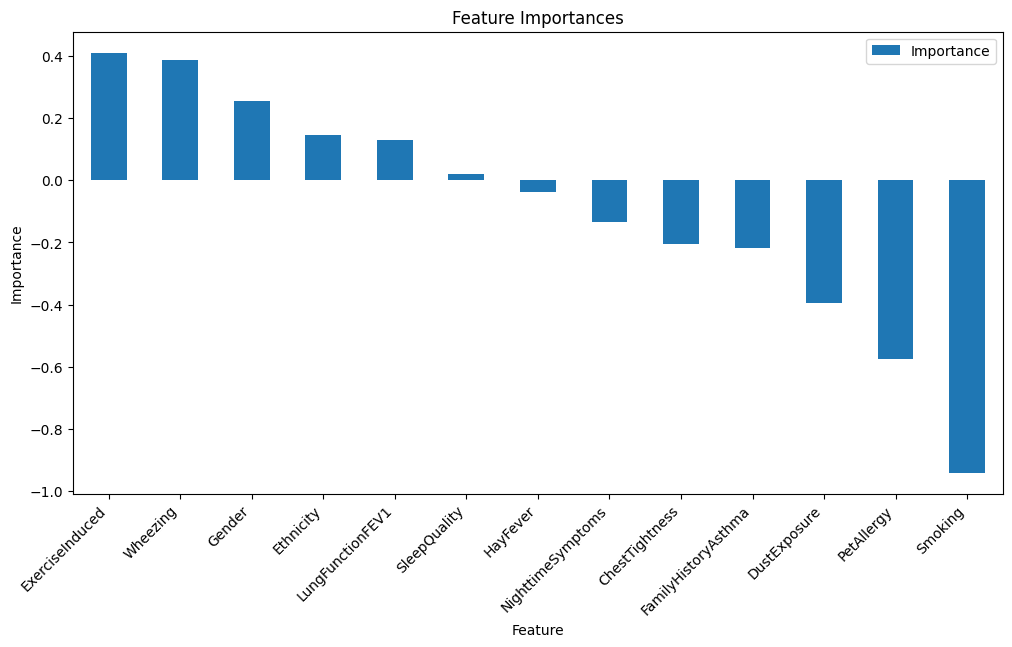

In [34]:
# Extract features used 
best_features_used_by_model = X_train.columns

# Get model coefficients (for LogisticRegression)
feature_importance = pipeline_clf["model"].coef_[0]

# Check lengths match
if len(best_features_used_by_model) != len(feature_importance):
    print(
        f"Warning: feature count ({len(best_features_used_by_model)}) "
        f"does not match importance count ({len(feature_importance)})."
    )

df_feature_importance = pd.DataFrame(
    {
        "Feature": best_features_used_by_model,
        "Importance": feature_importance[: len(best_features_used_by_model)],
    }
).sort_values(by="Importance", ascending=False)

print("* Features in descending importance:")
print(df_feature_importance["Feature"].to_list())

fig, ax = plt.subplots(figsize=(12, 6))
df_feature_importance.plot(kind="bar", x="Feature", y="Importance", ax=ax)

# Adjust labels/rotation for clarity
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_title("Feature Importances")
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.show()

Re-evaluate pipeline with best featues only on Train and Test sets.
  * Failed Recall (Recall for asthma ≥ 0.80 – to minimize false negatives (undiagnosed asthma cases predicted as non-asthma), ensuring sensitive detection of patients who actually have asthma)
  * Failed Precision (Precision for asthma ≥ 0.60 – to reduce false positives, avoiding over-identifying healthy patients as asthmatic)

In [35]:
clf_performance(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    pipeline=pipeline_clf,
    label_map=['No asthma', 'Asthma']
)

#### Train Set ####

---  Confusion Matrix  ---
                  Predicted No asthma  Predicted Asthma
Actual No asthma                 1019               568
Actual Asthma                      41                46


---  Classification Report  ---
              precision    recall  f1-score   support

   No asthma       0.96      0.64      0.77      1587
      Asthma       0.07      0.53      0.13        87

    accuracy                           0.64      1674
   macro avg       0.52      0.59      0.45      1674
weighted avg       0.92      0.64      0.74      1674
 

#### Test Set ####

---  Confusion Matrix  ---
                  Predicted No asthma  Predicted Asthma
Actual No asthma                  420               261
Actual Asthma                      19                18


---  Classification Report  ---
              precision    recall  f1-score   support

   No asthma       0.96      0.62      0.75       681
      Asthma       0.06      0.49      0.11        37

    accu

# Push files to Repo

Although the modeling and pipeline did not meet business requirements, all documents were saved for future reference. Code was taken from the Code Institutes "Churnometer" walktrhough project.

Saving the modeling pipeline:

In [36]:
version = 'v1'
file_path = f'outputs/modeling_pipeline/predict_asthma/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/modeling_pipeline/predict_asthma/v1'


Saving the Train set:

In [37]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Saving the Test set:

In [38]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Saving the data cleaning and feature engineering pipeline:

In [39]:
pipeline_data_cleaning_feat_eng

joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/modeling_pipeline/predict_asthma/v1/clf_pipeline_data_cleaning_feat_eng.pkl']

Saving the feature scaling and modeling pipeline:

In [40]:
pipeline_clf
joblib.dump(value=pipeline_clf ,
            filename=f"{file_path}/clf_pipeline_model.pkl")

['outputs/modeling_pipeline/predict_asthma/v1/clf_pipeline_model.pkl']

Save feature importance plot:

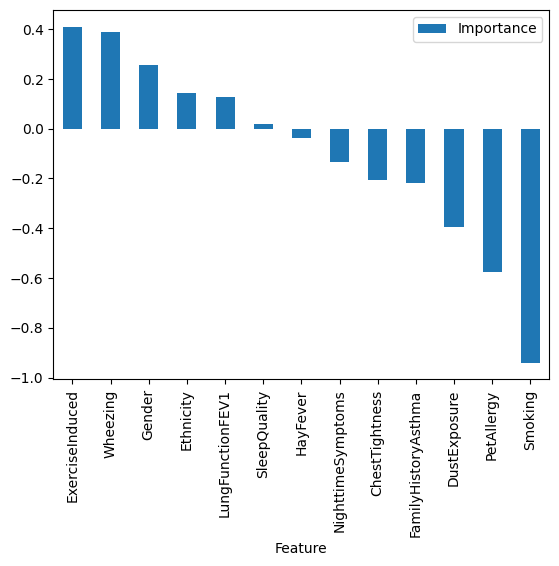

In [41]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

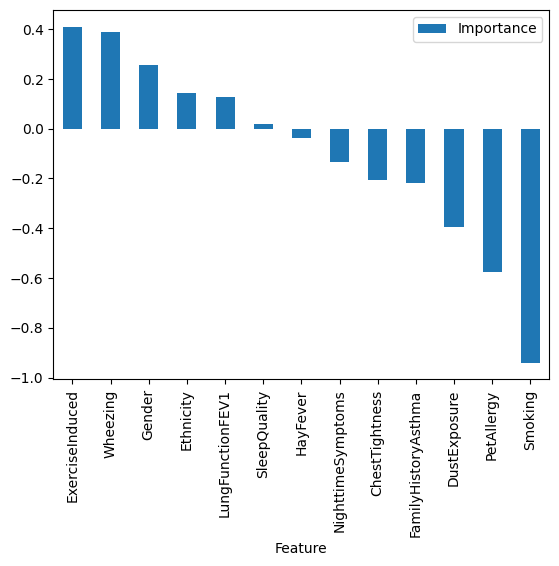

In [42]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')